[View in Colaboratory](https://colab.research.google.com/github/petroniocandido/pyFTS/blob/master/pyFTS/notebooks/GOOGLE%20COLAB%20-%20Benchmarks.ipynb)

# Example of Computational Experiments

## For running on Colab

In [1]:
!pip3 install -U git+https://github.com/petroniocandido/pyFTS
!git clone https://github.com/petroniocandido/stac

  Cloning https://github.com/petroniocandido/pyFTS to /tmp/pip-req-build-qz5k03k2
  Running setup.py bdist_wheel for pyFTS ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-6e0g6d7u/wheels/84/d7/1e/a333c7128f25b347640740859808db094c4478e98663cd2297
Successfully built pyFTS
  Found existing installation: pyFTS 1.2.2
    Uninstalling pyFTS-1.2.2:
      Successfully uninstalled pyFTS-1.2.2
Cloning into 'stac'...
remote: Counting objects: 2238, done.
remote: Total 2238 (delta 0), reused 0 (delta 0), pack-reused 2238
Receiving objects: 100% (2238/2238), 23.62 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (1147/1147), done.


## Common Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Common data transformations

In [3]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

boxcox = Transformations.BoxCox(0)

## Import Datasets

In [4]:
from pyFTS.data import TAIEX, NASDAQ, SP500

dataset_names = ["TAIEX", "SP500","NASDAQ"]

def get_dataset(name):
    if dataset_name == "TAIEX":
        return TAIEX.get_data()
    elif dataset_name == "SP500":
        return SP500.get_data()[11500:16000]
    elif dataset_name == "NASDAQ":
        return NASDAQ.get_data()


train_split = 2000
test_length = 200

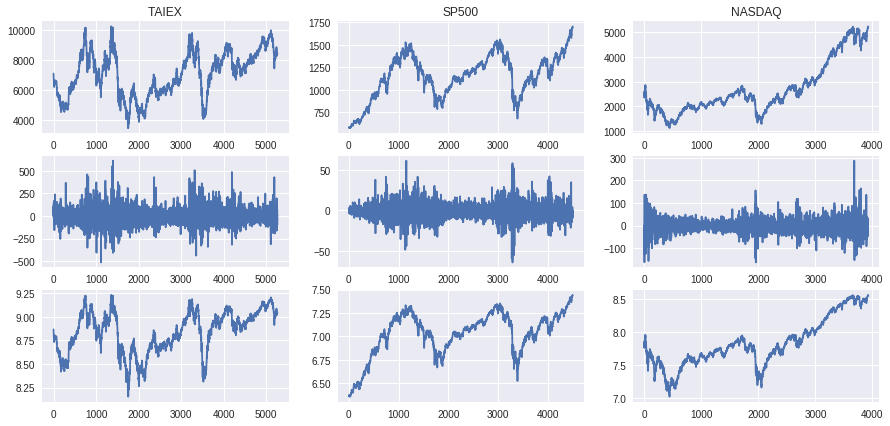

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[15,7])

for count,dataset_name in enumerate(dataset_names):
    dataset = get_dataset(dataset_name)
    dataset_diff = tdiff.apply(dataset)
    dataset_boxcox = boxcox.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[2][count].plot(dataset_boxcox)
    ax[0][count].set_title(dataset_name)

## Batch computational experiments with sliding_window_benchmarks

The **benchmarks.sliding_window_benchmarks** is a method that executes sliding window experiments on batch and store its results on a Sqlite3 database for posterior analysis. 

For each data window, a train and test datasets will be splitted. For each train split, number of partitions and partitioning method will be created a partitioner model. And for each partitioner, order, steps ahead and FTS method a foreasting model will be trained. The number of experiments is determined by 'windowsize' and 'inc' parameters.
 
 Then all trained models are benchmarked on the test data and the metrics are stored on a sqlite3 database (identified by the 'file' parameter) for posterior analysis.
 
 All these process can be distributed on a dispy cluster, setting the atributed 'distributed' to true and informing the list of dispy nodes on 'nodes' parameter. 
    
**Mandatory Parameters**

 - **data**: test data
 - **windowsize**: size of sliding window
 - **train**: percentual of sliding window data used to train the models

**kwargs optional arguments**
    
 - **benchmark_methods**:  a list with Non FTS models to benchmark. The default is None.
 - **benchmark_methods_parameters**:  a list with Non FTS models parameters. The default is None.
 - **dataset**: the dataset name to identify the current set of benchmarks results on database.
 - **distributed**: A boolean value indicating if the forecasting procedure will be distributed in a dispy cluster. . The default is False
 - **file**: file path to save the results. The default is benchmarks.db.
 - **inc**: a float on interval [0,1] indicating the percentage of the windowsize to move the window
 - **methods**: a list with FTS class names. The default depends on the forecasting type and contains the list of all FTS methods.
 - **models**: a list with prebuilt FTS objects. The default is None.
 - **nodes**: a list with the dispy cluster nodes addresses. The default is [127.0.0.1].
 - **orders**: a list with orders of the models (for high order models). The default is [1,2,3].
 - **partitions**: a list with the numbers of partitions on the Universe of Discourse. The default is [10].
 - **partitioners_models**: a list with prebuilt Universe of Discourse partitioners objects. The default is None.
 - **partitioners_methods**: a list with Universe of Discourse partitioners class names. The default is [partitioners.Grid.GridPartitioner].
 - **progress**: If true a progress bar will be displayed during the benchmarks. The default is False.
 - **start**: in the multi step forecasting, the index of the data where to start forecasting. The default is 0.
 - **steps_ahead**: a list with  the forecasting horizons, i. e., the number of steps ahead to forecast. The default is 1.
 - **tag**: a name to identify the current set of benchmarks results on database.
 - **type**: the forecasting type, one of these values: point(default), interval or distribution. The default is point.
 - **transformations**: a list with data transformations do apply . The default is [None].

The default file database name is 'benchmarks.db', and it contains a table named 'benchmarks' with the below schema:

|Field|Type|Description|
|-------|--------|-----------------|
|ID|integer|incremental primary key|
|Date| datetime |Date/hour of benchmark execution|
|Dataset|text| Identify on which dataset the dataset was performed|
|Tag|text| a user defined word that indentify a benchmark set|
|Type|varchar| forecasting type (point, interval, distribution)|
|Model|varchar| FTS model|
|Transformation|varchar| The name of data transformation, if one was used|
|Order|integer| the order of the FTS method |
|Scheme|text|UoD partitioner|
|Partitions|integer| Number of partitions|
|Size|integer| Number of rules of the FTS model  |
|Steps|integer| prediction horizon, i. e., the number of steps ahead|
|Measure|varchar| accuracy measure|
|Value|real| the measure value|

Know the sliding_window_benchmarks options:

In [6]:
from pyFTS.benchmarks import benchmarks as bchmk


## Partitioning optimization by dataset

**CAUTION**: This task is computationally expensive and take several hours to be performed. We strongly recommend to use the distributed version with a dispy cluster.

In [7]:
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.benchmarks import benchmarks as bchmk
from pyFTS.models import chen,yu

tag = 'partitioning'
_type = 'point'

for dataset_name in dataset_names:
    dataset = get_dataset(dataset_name)

    bchmk.sliding_window_benchmarks(dataset, 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS, yu.WeightedFTS],
                                    benchmark_models=False,
                                    transformations=[None],
                                    partitions=np.arange(10,100,2), 
                                    progress=False, type=_type,
                                    #distributed=True, nodes=['192.168.0.110', '192.168.0.107','192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)

    bchmk.sliding_window_benchmarks(dataset[:2000], 1000, train=0.8, inc=0.2,
                                    methods=[chen.ConventionalFTS, yu.WeightedFTS],
                                    benchmark_models=False,
                                    transformations=[tdiff],
                                    partitions=np.arange(3,30,1), 
                                    progress=False, type=_type,
                                    #distributed=True, nodes=['192.168.0.110', '192.168.0.107', '192.168.0.106'],
                                    file="benchmarks.db", dataset=dataset_name, tag=tag)


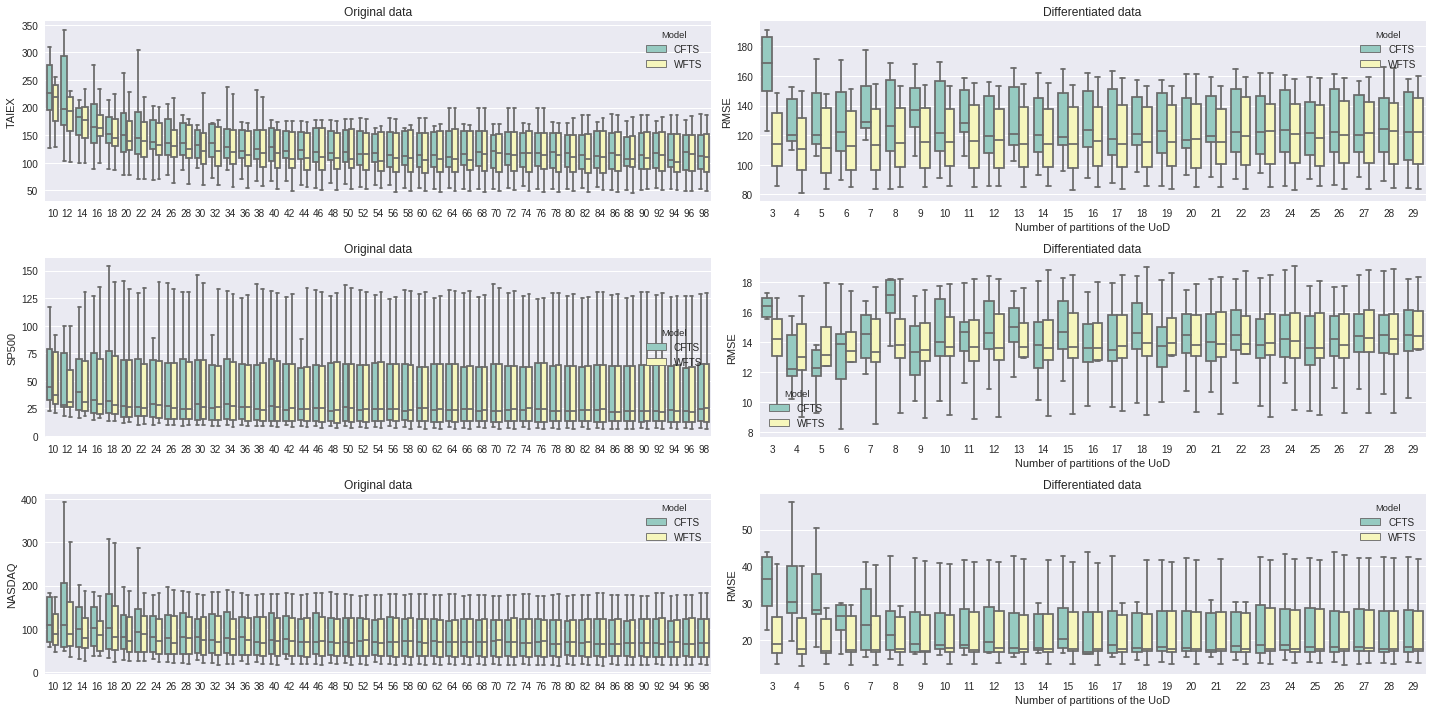

In [12]:
from pyFTS.benchmarks import Util as bUtil


fig, ax = plt.subplots(nrows=3, ncols=2, figsize=[20,10])
df1 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                "tag = 'partitioning' and measure = 'rmse'and transformation is null")

df2 = bUtil.get_dataframe_from_bd("benchmarks.db",
                                "tag = 'partitioning' and measure = 'rmse' and transformation is not null")

for count,dataset_name in enumerate(dataset_names):
  
  tmp1 = df1[(df1.Dataset == dataset_name)]
  tmp2 = df2[(df2.Dataset == dataset_name)]
  
  axis = ax[count][0]


  g1 = sns.boxplot(x='Partitions', y='Value', hue='Model', data=tmp1, showfliers=False, ax=axis, 
                 palette="Set3")
  axis.set_title("Original data")
  axis.set_ylabel(dataset_name)
  axis.set_xlabel("")
  
  axis = ax[count][1]

  g2 = sns.boxplot(x='Partitions', y='Value', hue='Model', data=tmp2, showfliers=False, ax=axis, 
                 palette="Set3")
  axis.set_title("Differentiated data")
  axis.set_ylabel("RMSE")
  axis.set_xlabel("Number of partitions of the UoD")
  
plt.tight_layout()